<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/update_2023/6_updated_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating a Cross-Sectional Momentum Strategy - updated 2023

## Load libraries and set plot defaults

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = TRUE, extra_libraries = c('lubridate', 'glue'), extra_dependencies = c())

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmp3K6XRD/remotes947a984467/RWLab-rwRtools-f742350/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.53.tar.gz’

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmp3K6XRD/remotes9469b0318f/Robot-Wealth-rsims-2589683/DESCRIPTION’ ... OK
* preparing ‘rsims’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘rsims_1.1.0.4.tar.gz’



## Auth and load data

In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()

# snippet: rw crypto load coincodex data v0.1
market_cap <- rwRtools::crypto_get_coincodex() %>%
  select(Ticker, Date, MarketCapUSD)

prices <- rwRtools::crypto_get_binance_spot_1h()

Authorization successful!

ℹ Downloading coincodex_marketcap.feather

✔ Saved coincodex_marketcap.feather to coincodex/coincodex_marketcap.feather  (…





File successfully transferred


ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 758.1 Mb )





File successfully transferred


## Create momentum feature

Create momentum feature before creating universe so that our universe consists of the top n coins by market cap *for which we have a momentum feature value.*

If we create the universe first, then calculate features on that universe, we can have coins in the universe that have no available momentum feature (for instnace during the coin's early life when we are unable to calculate a momentum feature over a lookback period).

Here we calculate a 20-day momentum feature to use as an example.

In [3]:
#' prices: Binance hourly OHLCV spot data
create_binance_daily_snapshots <- function(prices, snapshot_hour=12) {
  prices %>%
    # retain only the data we need and ditch USDT part of Ticker
    select(Ticker, Datetime, Close) %>%
    mutate(Ticker = str_replace(Ticker, "USDT$", "")) %>%
   # take a daily snapshot at a particular time
    mutate(
      Hour = hour(Datetime),
      Date = as_date(Datetime)
    ) %>%
    filter(Hour == snapshot_hour) %>%
    select(Date, Ticker, Close)
}

# create daily snapshots
daily_prices <- prices %>%
  create_binance_daily_snapshots(snapshot_hour = 22)

daily_prices <- daily_prices %>%
  group_by(Ticker) %>%
  arrange(Date) %>%
  # Calculate 20d momentum feature
  mutate(
    momo20 = Close / lag(Close, n = 20) - 1
  ) %>%
  na.omit() %>%
  ungroup()

head(daily_prices)

Date,Ticker,Close,momo20
<date>,<chr>,<dbl>,<dbl>
2017-09-07,BTC,4670.45,0.07693461
2017-09-07,ETH,337.00,0.09865032
2017-09-08,BTC,4285.99,0.04186934
2017-09-08,ETH,302.11,0.02849459
2017-09-09,BTC,4273.03,0.03213784
2017-09-09,ETH,298.00,0.02437180


## Create market-cap universe

In [4]:
#' market_cap: market cap data from coincodex
create_binance_universe <- function(prices, market_cap, n=10, min_constituents=10, stables, to_remove) {
  # Remove stablecoins and others
  prices <- prices %>%
    filter(!Ticker %in% c(stables, to_remove))

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(Date)) %>%
    pull(mindate)

  start_date <- start_date + 1

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  binance_universe <- prices %>%
    # this will remove any tickers that were removed from the prices data
    left_join(market_cap, by = c("Ticker", "Date")) %>%
    na.omit() %>%
    # but we need to create a new universe based on the remaining binance tickers (not all coincodex tickers were trading on binance)
    group_by(Date) %>%
    mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
    arrange(Date) %>%
    group_by(Ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & Date >= start_date) %>%
    na.omit() %>%
    ungroup()
}

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# duplicates and others to remove
to_remove <- c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')

# create universe
universe <- create_binance_universe(daily_prices, market_cap, n=10, min_constituents=10, stables=stables, to_remove=to_remove)

head(universe)

Date,Ticker,Close,momo20,MarketCapUSD,cap_rank,is_index
<date>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
2017-09-07,BTC,4670.45,0.07693461,75581470763,1,FALSE
2017-09-07,ETH,337.00,0.09865032,30818770935,2,FALSE
2017-09-08,BTC,4285.99,0.04186934,73748559954,1,FALSE
2017-09-08,ETH,302.11,0.02849459,29641283189,2,FALSE
2017-09-09,BTC,4273.03,0.03213784,69792799202,1,FALSE
2017-09-09,ETH,298.00,0.02437180,27692911486,2,FALSE


In [7]:
universe_start_date <- universe %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  summarise(index_count = sum(is_index)) %>%
  filter(index_count >= 10) %>%
  summarise(first_index_date = first(Date)) %>%
  pull()

universe_start_date

[1] "2018-06-21"

## Simulation

### Simulation function

TODO:
- Consider refactoring
- Pull out update positions logic into function - make it so that we can use different methods by calling different functions

In [8]:
#' Cash Accounting Backtest
#'
#' @param prices Matrix of trade prices. Column 1 must be the timestamp or index.
#' @param theo_weights Matrix of theoretical weights. Column 1 must be the timestamp or index.
#' @param trade_buffer Trade buffer parameter
#' @param initial_cash Inital cash balance
#' @param commission_pct Percent commission charged on trades
#' @param capitalise_profits If TRUE, utilise profits and initial cash balance in determining position sizes. If FALSE, profits accrue as a cash balance and are not reinvested.
#'
#' @return long dataframe of results - dates, trades, commissions, value of portfolio components
#' @details
#' `theo_weights` should be date-aligned with `prices` - it is up to the user to lag `theo_weights` as necessary to
#' ensure that trades occur at appropriate prices.
cash_backtest <- function(prices, theo_weights, trade_buffer = 0., initial_cash = 10000, commission_pct = 0, capitalise_profits = FALSE) {
  # get tickers for later
  tickers <- colnames(prices)[-1] %>%
    stringr::str_remove("Close_")

  # initial state
  num_assets <- ncol(prices) - 1  # -1 for date column
  current_positions <- rep(0, num_assets)
  previous_theo_weights <- rep(0, num_assets)
  row_list <- vector(mode = "list", length = nrow(prices))  # preallocate for slight speedup
  cash <- initial_cash

  # backtest loop
  for(i in 1:nrow(prices)) {
    # TODO: does wrapping in as.numeric() speed up? (creates array as opposed to named vector). Don't need the names later?
    # TODO: check that date is first column in backtest_theo_weights and backtest_prices
    current_date <- prices[i, "Date"]
    current_prices <- prices[i, -1]
    current_theo_weights <- theo_weights[i, -1]

    # update equity
    equity <- sum(current_positions * current_prices, na.rm = TRUE) + cash
    cap_equity <- ifelse(capitalise_profits, equity, min(initial_cash, equity))  # min reflects assumption that we don't top up strategy equity if in drawdown

    # update positions based on no-trade buffer
    # TODO: consider commissions in calculating position sizes (otherwise can go over leverage 1)
    current_weights <- current_positions*current_prices/cap_equity
    target_positions <- current_positions
    for(j in 1:num_assets) {
      if(is.na(current_theo_weights[j]) || current_theo_weights[j] == 0) {
        target_positions[j] <- 0
        next
      }
      # note: we haven't truncated to nearest whole coin, as coins are divisible (unlike shares)
      if(current_weights[j] < current_theo_weights[j] - trade_buffer) {
        target_positions[j] <- (current_theo_weights[j] - trade_buffer)*cap_equity/current_prices[j]
      } else if(current_weights[j] > current_theo_weights[j] + trade_buffer) {
        target_positions[j] <- (current_theo_weights[j] + trade_buffer)*cap_equity/current_prices[j]
      }
    }

    # calculate position deltas, trade values and commissions
    trades <- target_positions - current_positions
    trade_value <- trades * current_prices
    commissions <- abs(trade_value) * commission_pct

    # adjust cash by value of trades
    cash <- cash - sum(trade_value, na.rm = TRUE) - sum(commissions, na.rm = TRUE)
    current_positions <- target_positions
    position_value <- current_positions * current_prices
    equity <- sum(position_value, na.rm = TRUE) + cash

    # store date in matrix as numeric (then convert date back to date format later)
      row_mat <- matrix(
        data = c(
          rep(as.numeric(current_date), num_assets + 1),
          c(1, current_prices),
          c(0, current_positions),
          c(cash, position_value),
          c(0, trades),
          c(-sum(trade_value), trade_value),
          c(0, commissions)
        ),
        nrow = num_assets + 1,
        ncol = 7,
        byrow = FALSE,
        dimnames = list(
          # tickers are row names
          c("Cash", tickers),
          # column names
          c("Date", "Close", "Position", "Value", "Trades", "TradeValue", "Commission")
        )
      )

    row_list[[i]] <- row_mat

    previous_theo_weights <- current_theo_weights
  }

  # Combine list of matrixes into dataframe
  do.call(rbind, row_list) %>%
    as_tibble(rownames = "Ticker") %>%
    mutate(
      Date = as.Date(Date, origin ="1970-01-01")
    )
}

### Make wide dataframe with backtest prices and aligned signals

This is where we convert our factor(s) into wide matrixes of target weights and prices.  Many ways to do this - here we allocate a weight proportional to the rank of the momentum feature and allow long and short positions.

Regardless of how it's done, the end results needs to be a (wide) matrix of prices and a (wide) matrix of theoretical weights. Weights need to be date-aligned with the price at which they are traded. Here, we assume we can trade at the close on the day of the signal.

For the first 21 days of our universe, we have 9 tradable assets because when the tenth asset gets added, it needs 20 days to calculate the first momo20 value.

In [9]:
# weight by rank (mean(rank) - rank), scaled to abs(weight) = 1, long-short
backtest_df <- universe %>%
  filter(Date >= universe_start_date) %>%
  select(Ticker, Date, Close, is_index, momo20) %>%
  # can't filter on is_index because we need price on day after it drops out of index
  # instead, replace momo values with NA if not in index then rank each day
  mutate(universe_momo20 = case_when(is_index == TRUE ~ momo20, TRUE ~ NA_real_)) %>%
  group_by(Date) %>%
  mutate(
    rank = row_number(universe_momo20),
    weight = rank - mean(rank, na.rm = TRUE),
    theo_weight = weight/(sum(abs(weight), na.rm = TRUE))
  ) %>%
  select(Ticker, Date, Close, theo_weight) %>%
  pivot_wider(names_from = Ticker, values_from = c(Close, theo_weight))  # pivot wider guarantees prices and theo_weight are date aligned

head(backtest_df)

Date,Close_ADA,Close_BNB,Close_BTC,Close_EOS,Close_ETH,Close_LTC,Close_NEO,Close_QTUM,Close_XLM,⋯,theo_weight_LOOM,theo_weight_RDNT,theo_weight_EDU,theo_weight_SUI,theo_weight_FLOKI,theo_weight_PEPE,theo_weight_SNT,theo_weight_MAV,theo_weight_PENDLE,theo_weight_ARKM
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-06-21,0.15821,16.9407,6724.75,10.3966,526.65,96.82,37.580,10.204,0.22677,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-22,0.13948,15.3934,6071.07,8.7092,463.81,85.48,33.120,9.014,0.20170,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-23,0.13868,15.7099,6191.26,8.4839,476.40,83.14,34.300,8.870,0.20282,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-24,0.13050,14.4368,6136.79,8.0400,453.72,81.35,31.287,7.994,0.19338,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-25,0.13524,14.8145,6234.14,8.3422,460.12,81.72,31.700,8.305,0.19751,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-26,0.12865,14.1117,6155.75,7.8004,438.47,77.27,30.510,8.527,0.18585,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Conduct some checks on our backtest dataframe:
* weights sum to 1 every day
* maximum and minimum weights are consistent
* number of non-NA positions is consistent

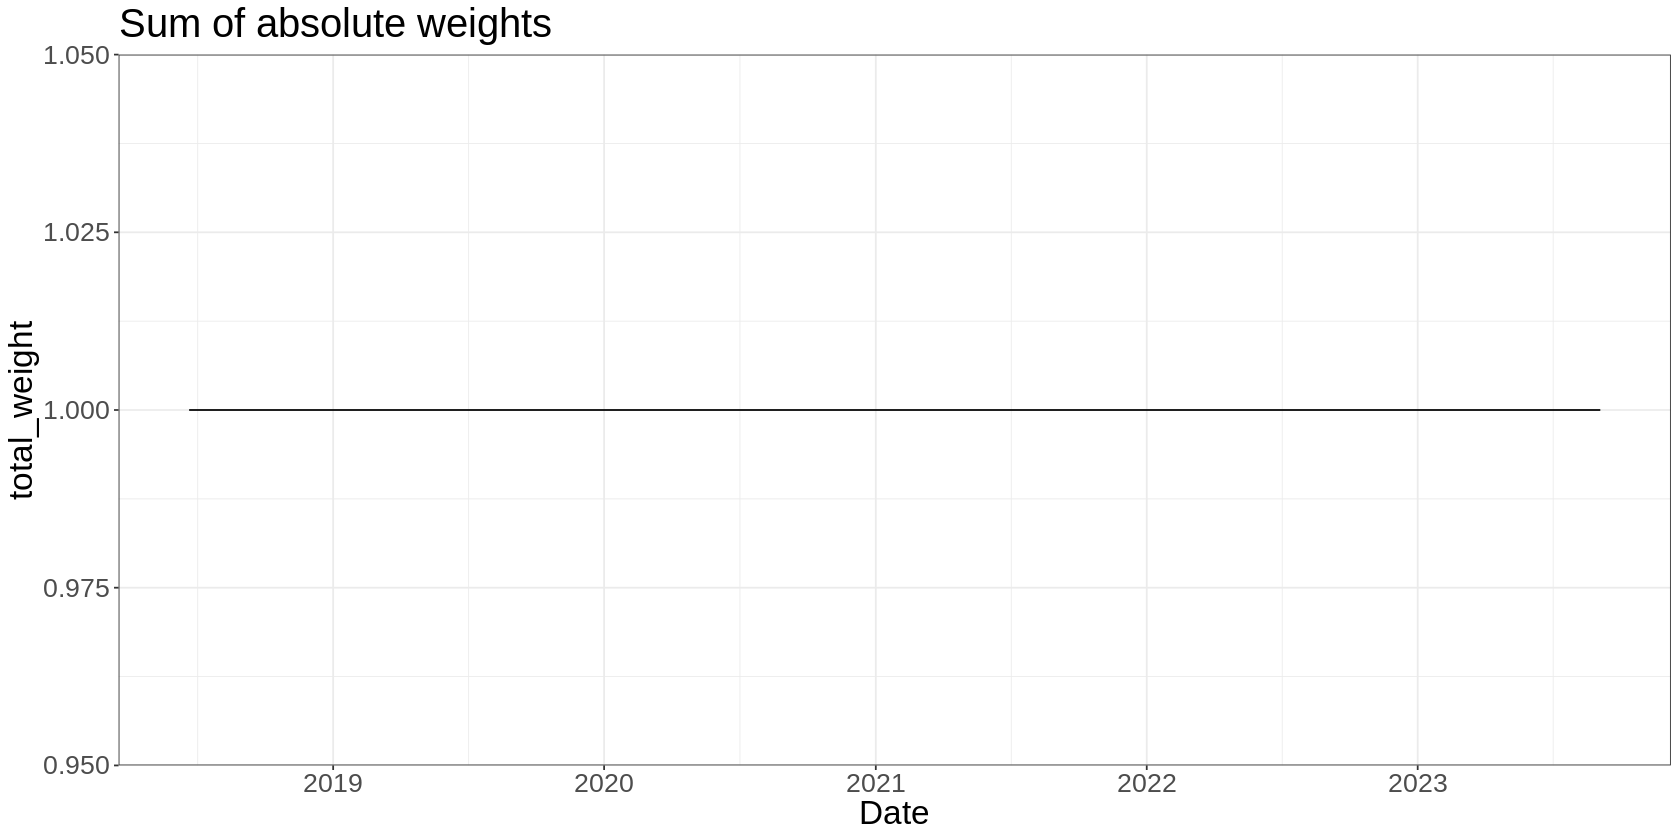

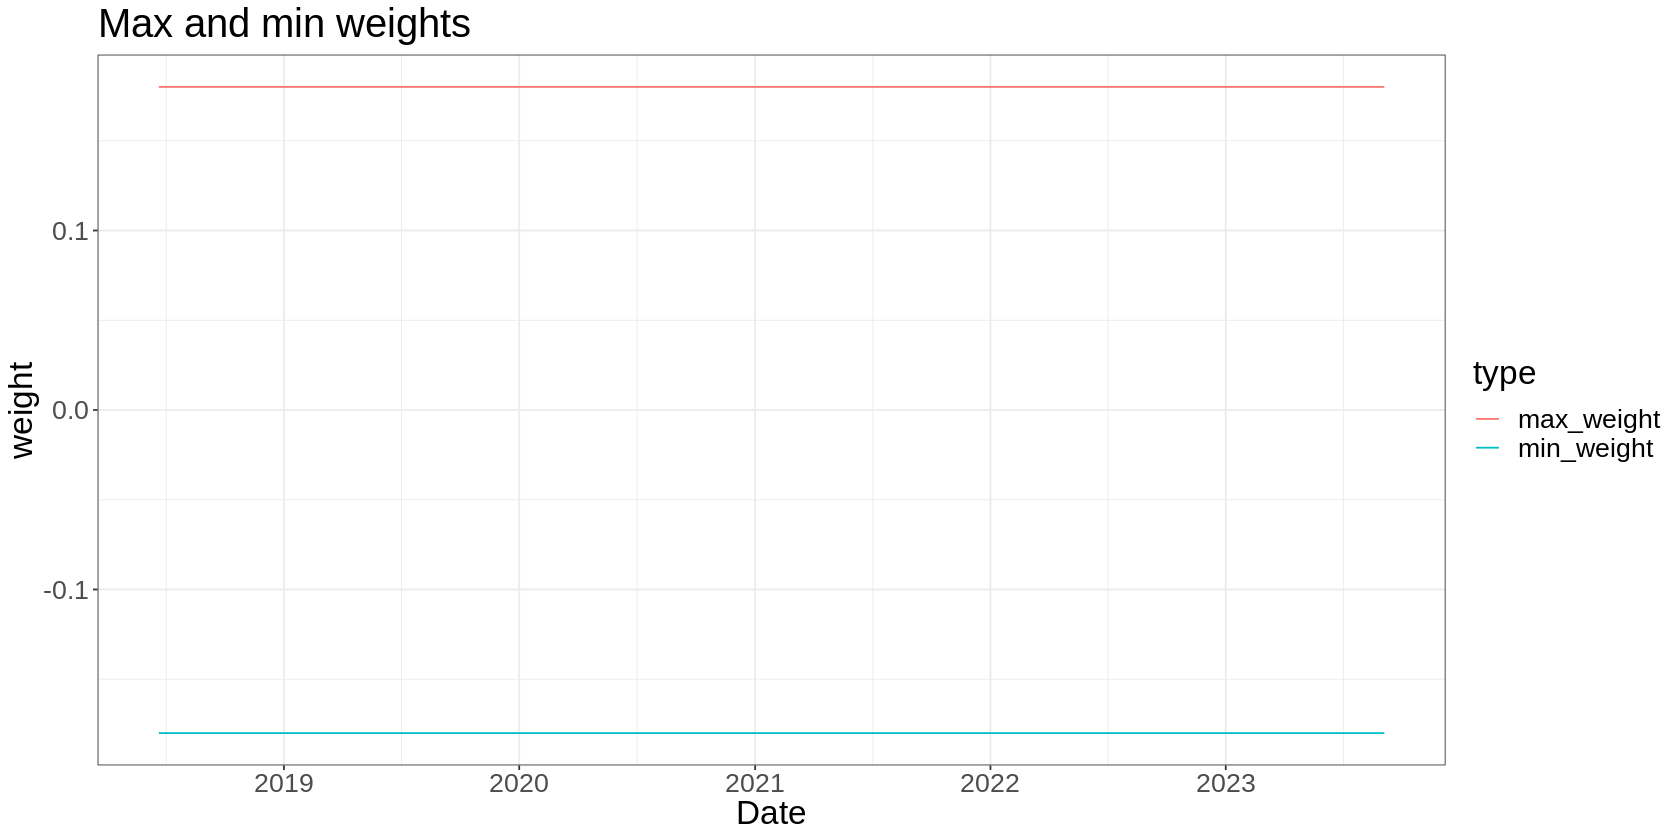

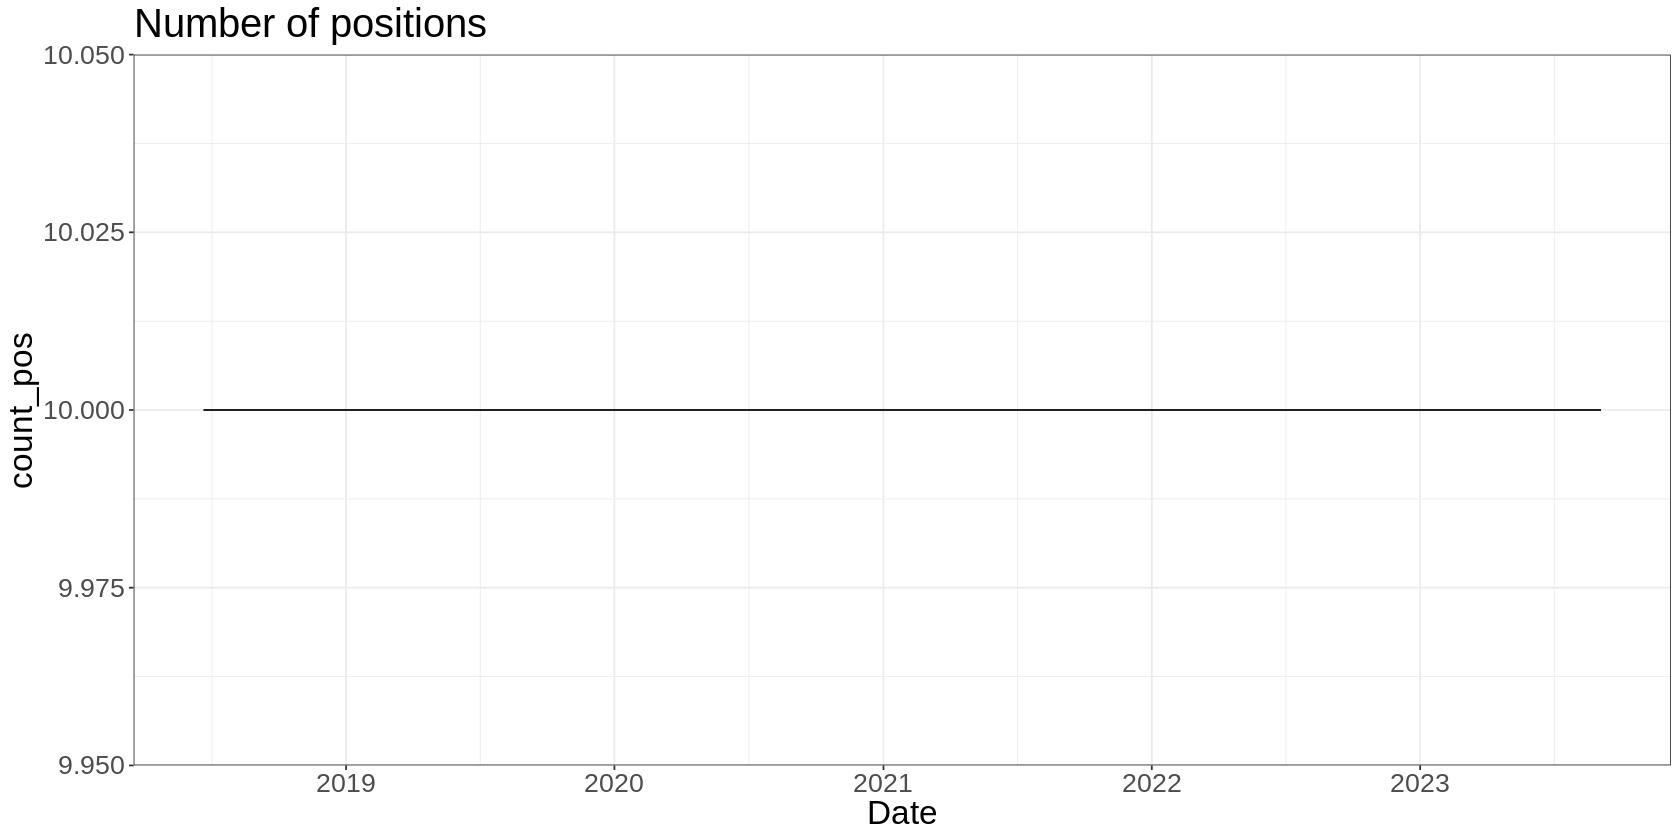

In [11]:
# check weights sum to 1
checks_df <- universe %>%
  filter(Date >= universe_start_date) %>%
  select(Ticker, Date, Close, is_index, momo20) %>%
  # can't filter on is_index because we need price on day after it drops out of index
  # instead, replace momo values with NA if not in index then rank each day
  mutate(universe_momo20 = case_when(is_index == TRUE ~ momo20, TRUE ~ NA_real_)) %>%
  group_by(Date) %>%
  mutate(
    rank = row_number(universe_momo20),
    weight = rank - mean(rank, na.rm = TRUE),
    theo_weight = weight/(sum(abs(weight), na.rm = TRUE))
  ) %>%
  select(Ticker, Date, Close, weight, theo_weight)

checks_df %>%
  summarise(total_weight = sum(abs(theo_weight), na.rm = TRUE)) %>%
  ggplot(aes(x = Date, y = total_weight)) +
    geom_line() +
    labs(
      title = "Sum of absolute weights"
    )

checks_df %>%
  summarise(
    min_weight = min(theo_weight, na.rm = TRUE),
    max_weight = max(theo_weight, na.rm = TRUE)
  ) %>%
  pivot_longer(-Date, names_to = "type", values_to = "weight") %>%
  ggplot(aes(x = Date, y = weight, colour = type)) +
    geom_line() +
    labs(
      title = "Max and min weights"
    )

checks_df %>%
  summarise(
    count_pos = sum(!is.na(theo_weight))
  ) %>%
  ggplot(aes(x = Date, y = count_pos)) +
    geom_line() +
    labs(
      title = "Number of positions"
    )

Our weights always sum to 1. The max and min weights hover around +/-0.18.

We always have 10 positions.

### Get weights and prices as matrixes for simulation

In [14]:
# get weights as a wide matrix (could do equal weight, in proportion to factor/signal, top n etc)
# here we do proportional to factor rank and allow long-short
# note that date column will get converted to unix timestamp
# note that when our universe is young, we might not have 10 tradables since we need some lookback period to calculate the first factor value for the tenth asset.
backtest_theo_weights <- backtest_df %>%
  select(Date, starts_with("theo_weight_")) %>%
  data.matrix()

# NA weights should be zero
backtest_theo_weights[is.na(backtest_theo_weights)] <- 0

head(backtest_theo_weights)

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- backtest_df %>%
  select(Date, starts_with("Close")) %>%
  data.matrix()

head(backtest_prices)

Date,theo_weight_ADA,theo_weight_BNB,theo_weight_BTC,theo_weight_EOS,theo_weight_ETH,theo_weight_LTC,theo_weight_NEO,theo_weight_QTUM,theo_weight_XLM,⋯,theo_weight_LOOM,theo_weight_RDNT,theo_weight_EDU,theo_weight_SUI,theo_weight_FLOKI,theo_weight_PEPE,theo_weight_SNT,theo_weight_MAV,theo_weight_PENDLE,theo_weight_ARKM
17703,-0.10,0.18,0.10,0.02,0.14,-0.02,-0.18,-0.14,-0.06,⋯,0,0,0,0,0,0,0,0,0,0
17704,-0.10,0.18,0.14,-0.14,0.10,0.02,-0.18,-0.06,-0.02,⋯,0,0,0,0,0,0,0,0,0,0
17705,-0.06,0.18,0.14,-0.18,0.10,-0.02,-0.14,-0.10,0.02,⋯,0,0,0,0,0,0,0,0,0,0
17706,-0.06,0.18,0.14,-0.10,0.10,0.02,-0.14,-0.18,-0.02,⋯,0,0,0,0,0,0,0,0,0,0
17707,-0.06,0.18,0.14,-0.14,0.10,-0.02,-0.18,-0.10,0.02,⋯,0,0,0,0,0,0,0,0,0,0
17708,-0.10,0.18,0.14,-0.18,0.10,0.02,-0.14,-0.02,-0.06,⋯,0,0,0,0,0,0,0,0,0,0


Date,Close_ADA,Close_BNB,Close_BTC,Close_EOS,Close_ETH,Close_LTC,Close_NEO,Close_QTUM,Close_XLM,⋯,Close_LOOM,Close_RDNT,Close_EDU,Close_SUI,Close_FLOKI,Close_PEPE,Close_SNT,Close_MAV,Close_PENDLE,Close_ARKM
17703,0.15821,16.9407,6724.75,10.3966,526.65,96.82,37.580,10.204,0.22677,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17704,0.13948,15.3934,6071.07,8.7092,463.81,85.48,33.120,9.014,0.20170,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17705,0.13868,15.7099,6191.26,8.4839,476.40,83.14,34.300,8.870,0.20282,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17706,0.13050,14.4368,6136.79,8.0400,453.72,81.35,31.287,7.994,0.19338,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17707,0.13524,14.8145,6234.14,8.3422,460.12,81.72,31.700,8.305,0.19751,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17708,0.12865,14.1117,6155.75,7.8004,438.47,77.27,30.510,8.527,0.18585,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Simulate

First, no costs:

In [15]:
# fees - reasonable approximation of actual costs (spread + market impact + commission)
fees <- tribble(
  ~tier, ~fee,
  0, 0.,  # use for cost-free simulations
  1, 0.001,
  2, 0.0015,
  3, 0.0020,
  4, 0.0025,
  5, 0.0030,
  6, 0.0035,
  7, 0.0040,
  8, 0.0005
)

# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
fee_tier <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)

head(results_df)

Ticker,Date,Close,Position,Value,Trades,TradeValue,Commission
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cash,2018-06-21,1.00000,0.0000000,10000,0.0000000,NA,0
ADA,2018-06-21,0.15821,-6320.7129764,-1000,-6320.7129764,-1000,0
BNB,2018-06-21,16.94070,106.2529884,1800,106.2529884,1800,0
BTC,2018-06-21,6724.75000,0.1487044,1000,0.1487044,1000,0
EOS,2018-06-21,10.39660,19.2370583,200,19.2370583,200,0
ETH,2018-06-21,526.65000,2.6583120,1400,2.6583120,1400,0


### Simulation results

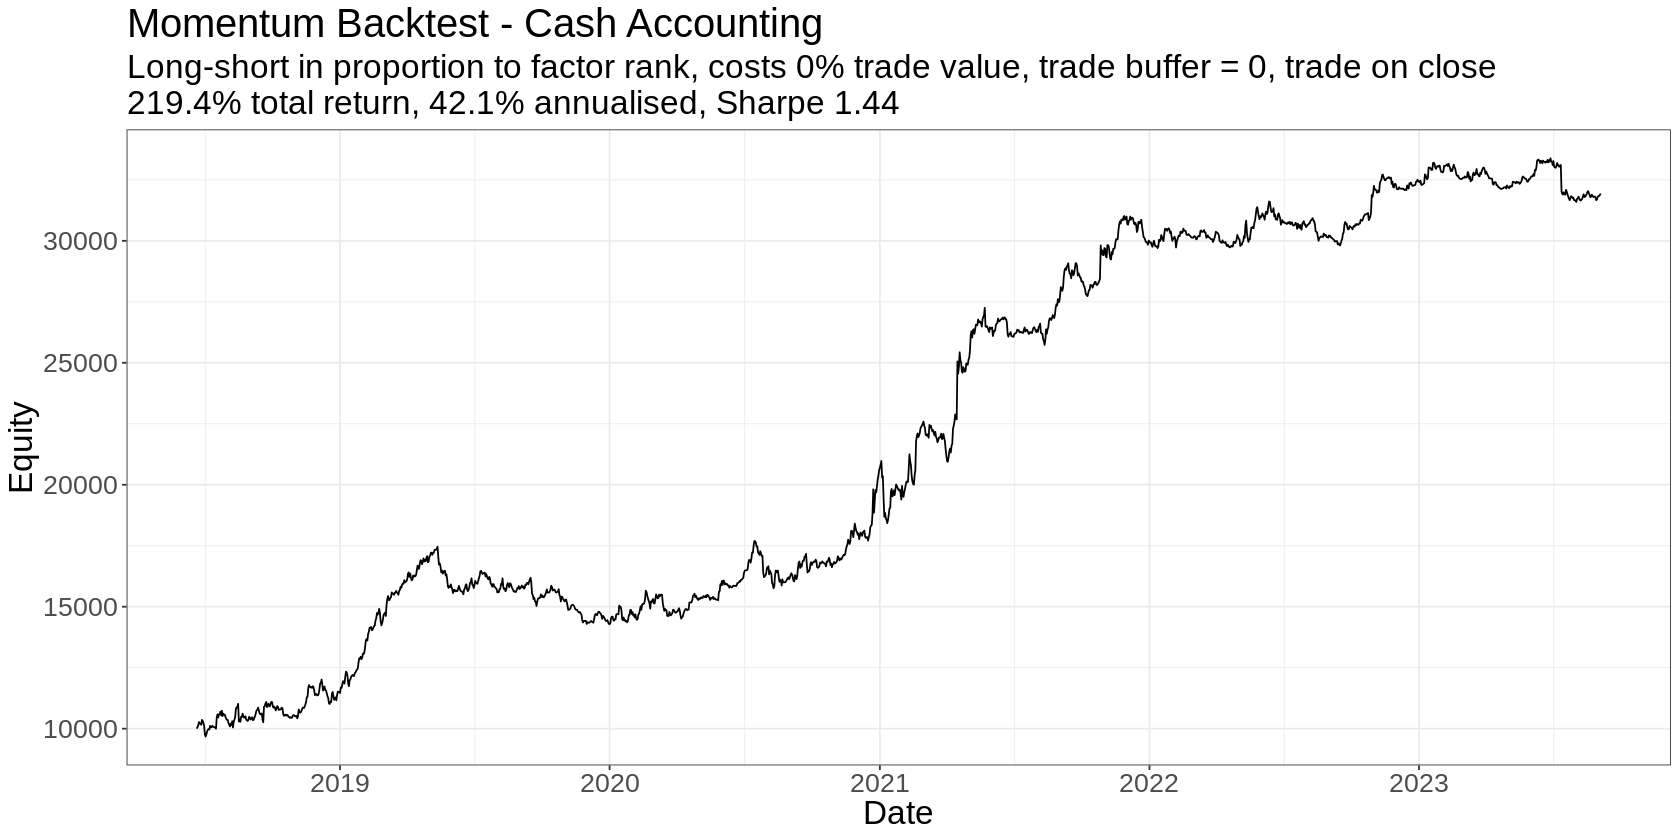

In [18]:
plot_results <- function(backtest_results, weighting_protocol = "Long-short in proportion to factor rank") {
  equity_curve <- backtest_results %>%
    group_by(Date) %>%
    summarise(Equity = sum(Value, na.rm = TRUE))

  fin_eq <- equity_curve %>%
    tail(1) %>%
    pull(Equity)

  init_eq <- equity_curve %>%
    head(1) %>%
    pull(Equity)

  total_return <- (fin_eq/init_eq - 1) * 100
  days <- nrow(equity_curve)
  ann_return <- total_return * 365/days
  sharpe <- equity_curve %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()

  equity_curve %>%
    ggplot(aes(x = Date, y = Equity)) +
      geom_line() +
      labs(
        title = "Momentum Backtest - Cash Accounting",
        subtitle = glue(
          "{weighting_protocol}, costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on close
          {round(total_return, 1)}% total return, {round(ann_return, 1)}% annualised, Sharpe {round(sharpe, 2)}"
        )
      )
}

plot_results(results_df)

Backtest with costs


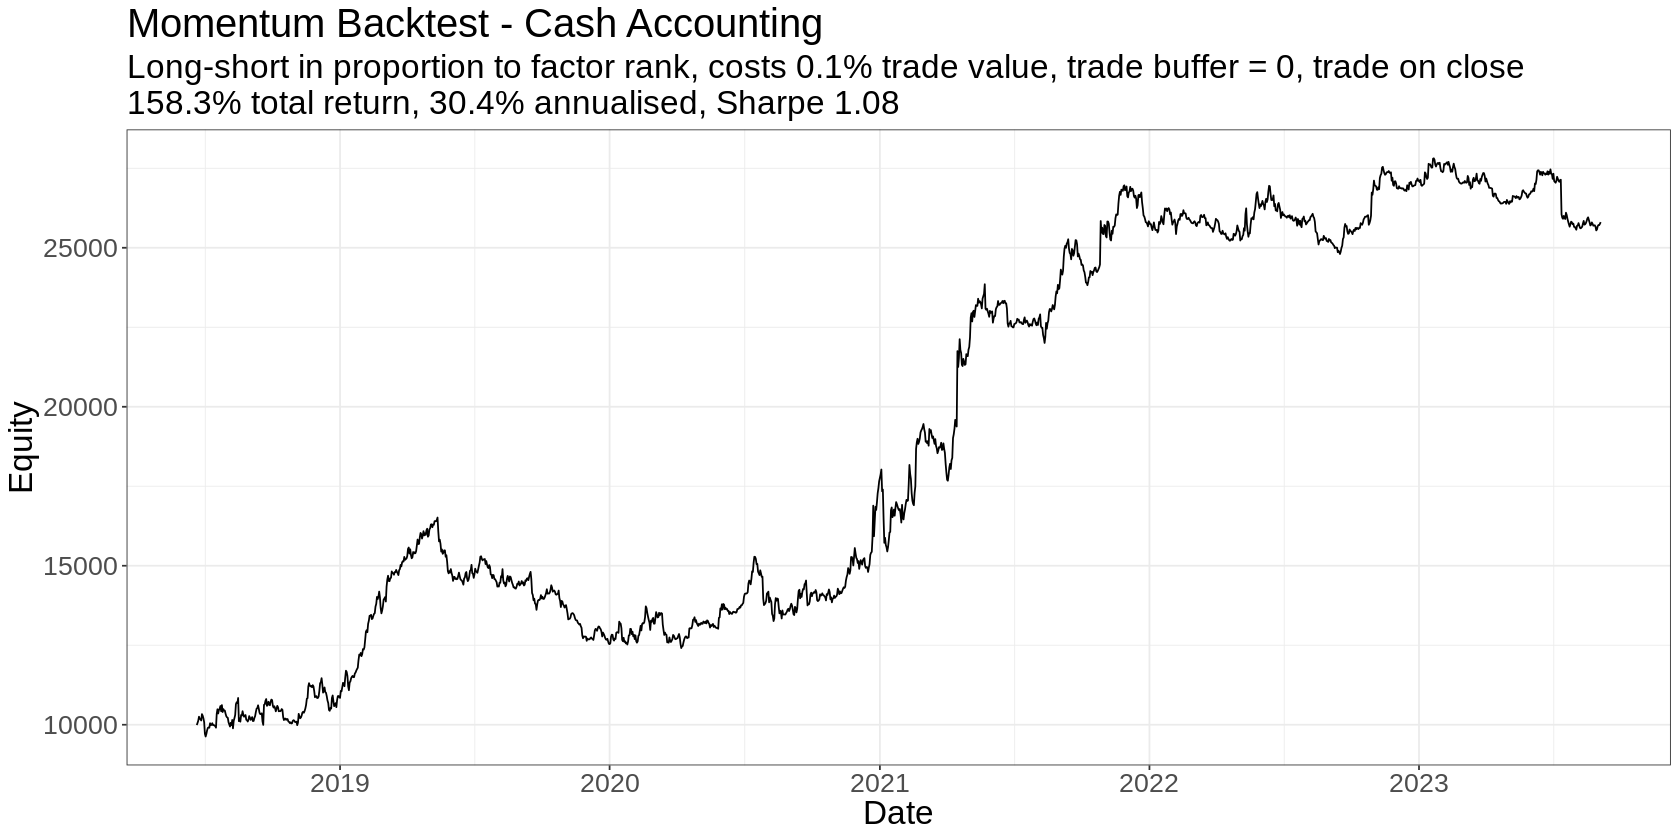

In [19]:
fee_tier <- 1
commission_pct <- fees$fee[fees$tier==fee_tier]

results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)
plot_results(results_df)

### Trade buffer parameter

We don't always necessarily want to do trades according to our theoretical weights, for example if the cost to do the trade is large compared to expected returns.

We use the concept of a "trade buffer". For each coin:
* If the current weight is less than the current theoretical weight less the trade buffer, we buy up to the current theoretical weight less the trade buffer.
* If the current weight is greater than the current theoretical weight plus the trade buffer, we sell down to the current theoretical weight plus the trade buffer.

*That is, we trade the bare minimum possible, up to the edge of our "trade buffer".*

We then tune the trade buffer parameter via simualtion.

Let's start by picking an arbitrary value:

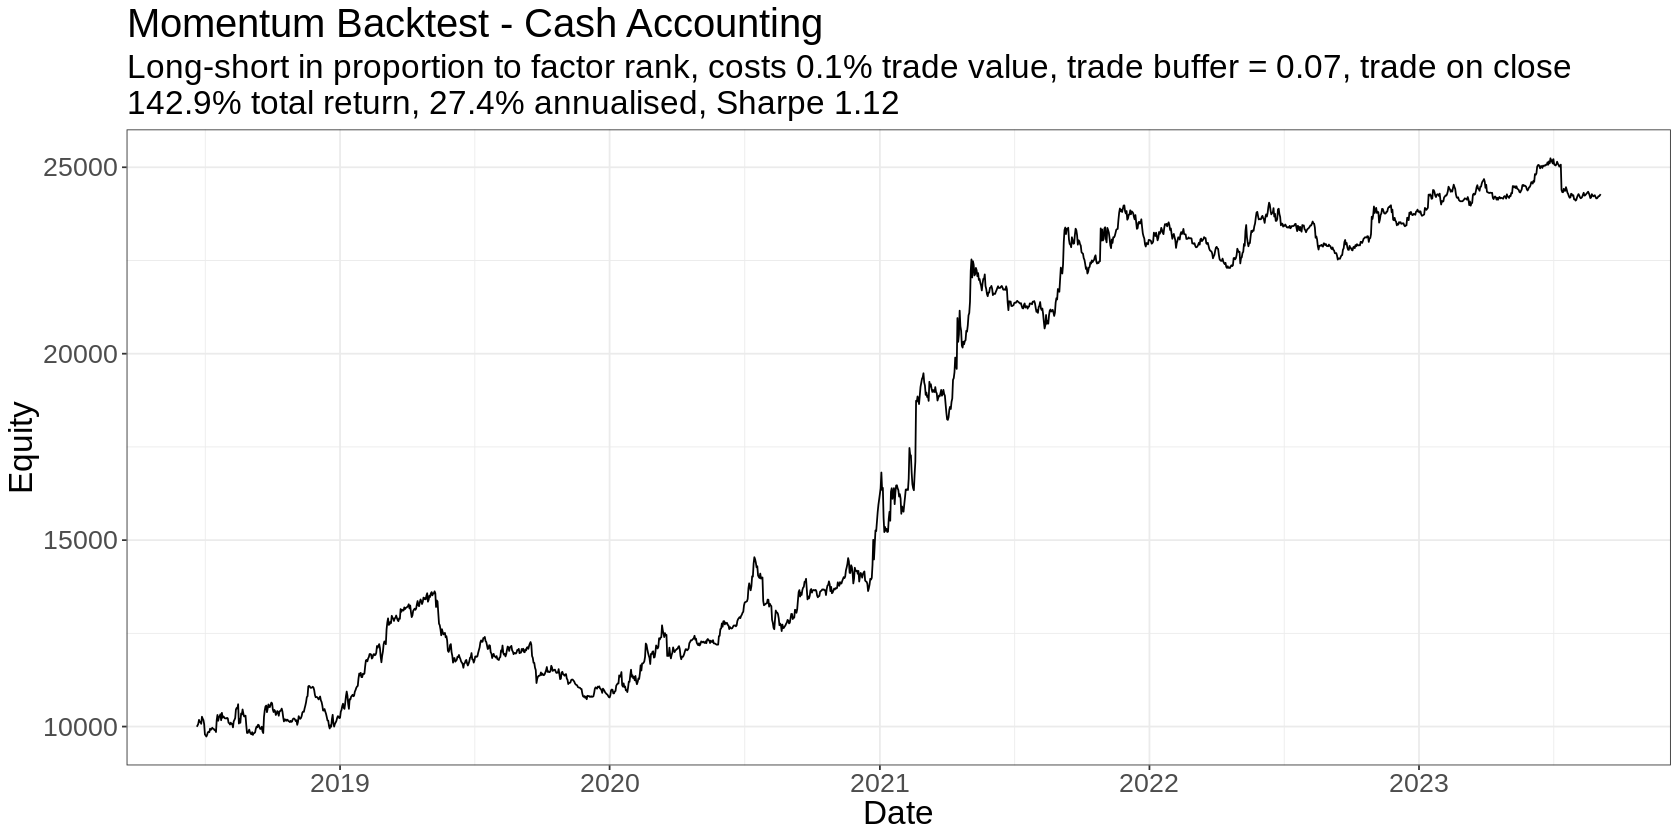

In [20]:
trade_buffer <- 0.07

results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)
plot_results(results_df)

What's our historical Sharpe-optimal trade buffer parameter?

In [21]:
calc_sharpe <- function(backtest_results) {
  backtest_results %>%
    group_by(Date) %>%
    summarise(Equity = sum(Value, na.rm = TRUE)) %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()
}

sharpes <- list()
trade_buffers <- seq(0, 0.1, by = 0.005)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes,
    cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits) %>%
      calc_sharpe()
  )
}

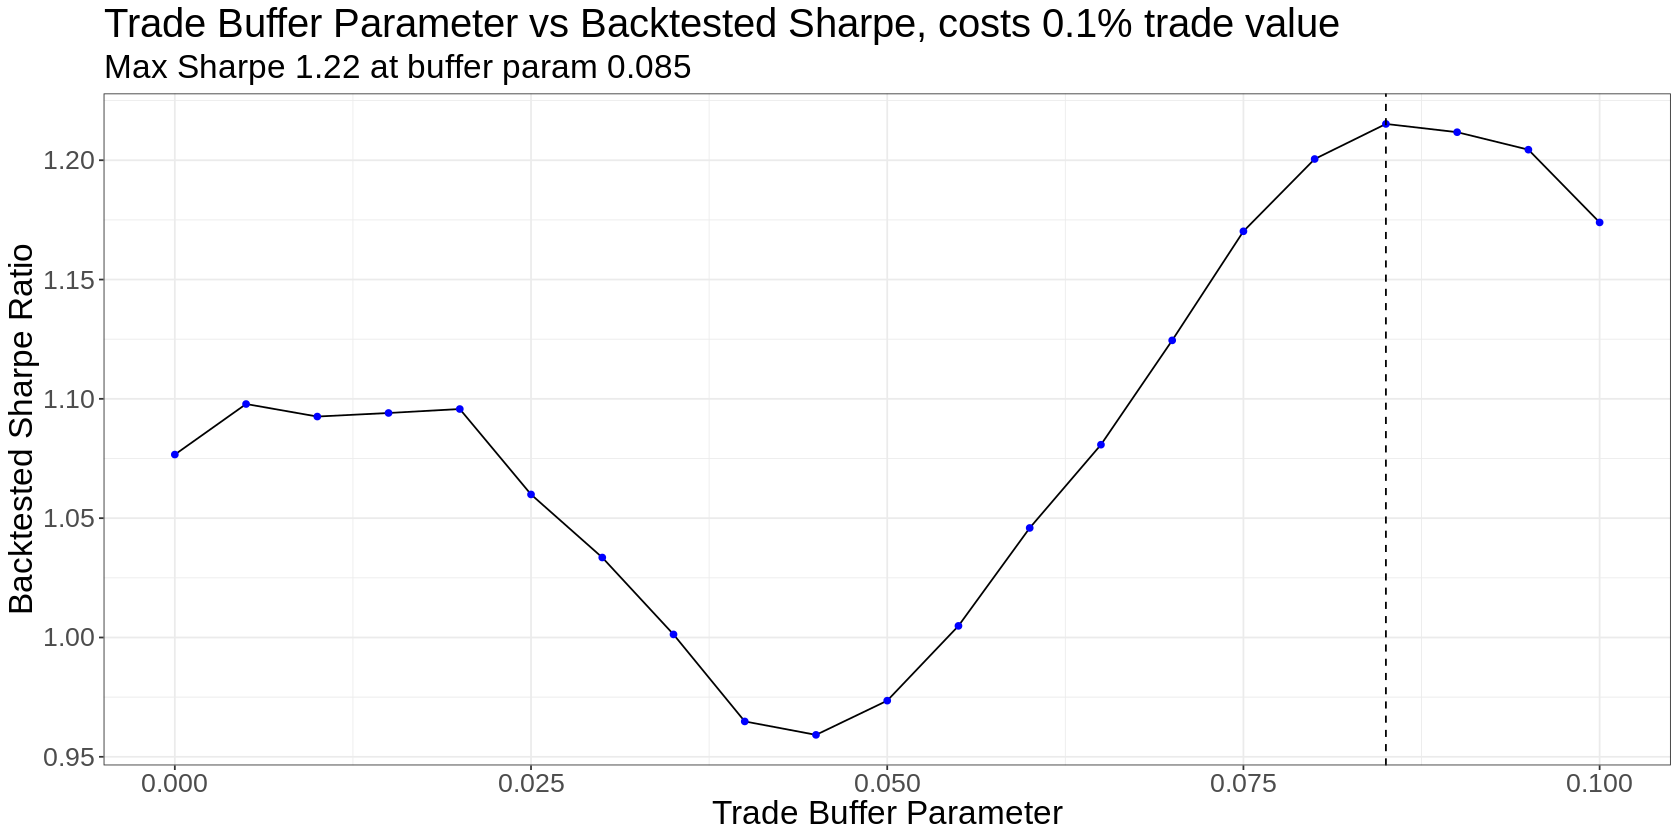

In [22]:
sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers,
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

Now let's backtest at our historically optimal trade buffer parameter:

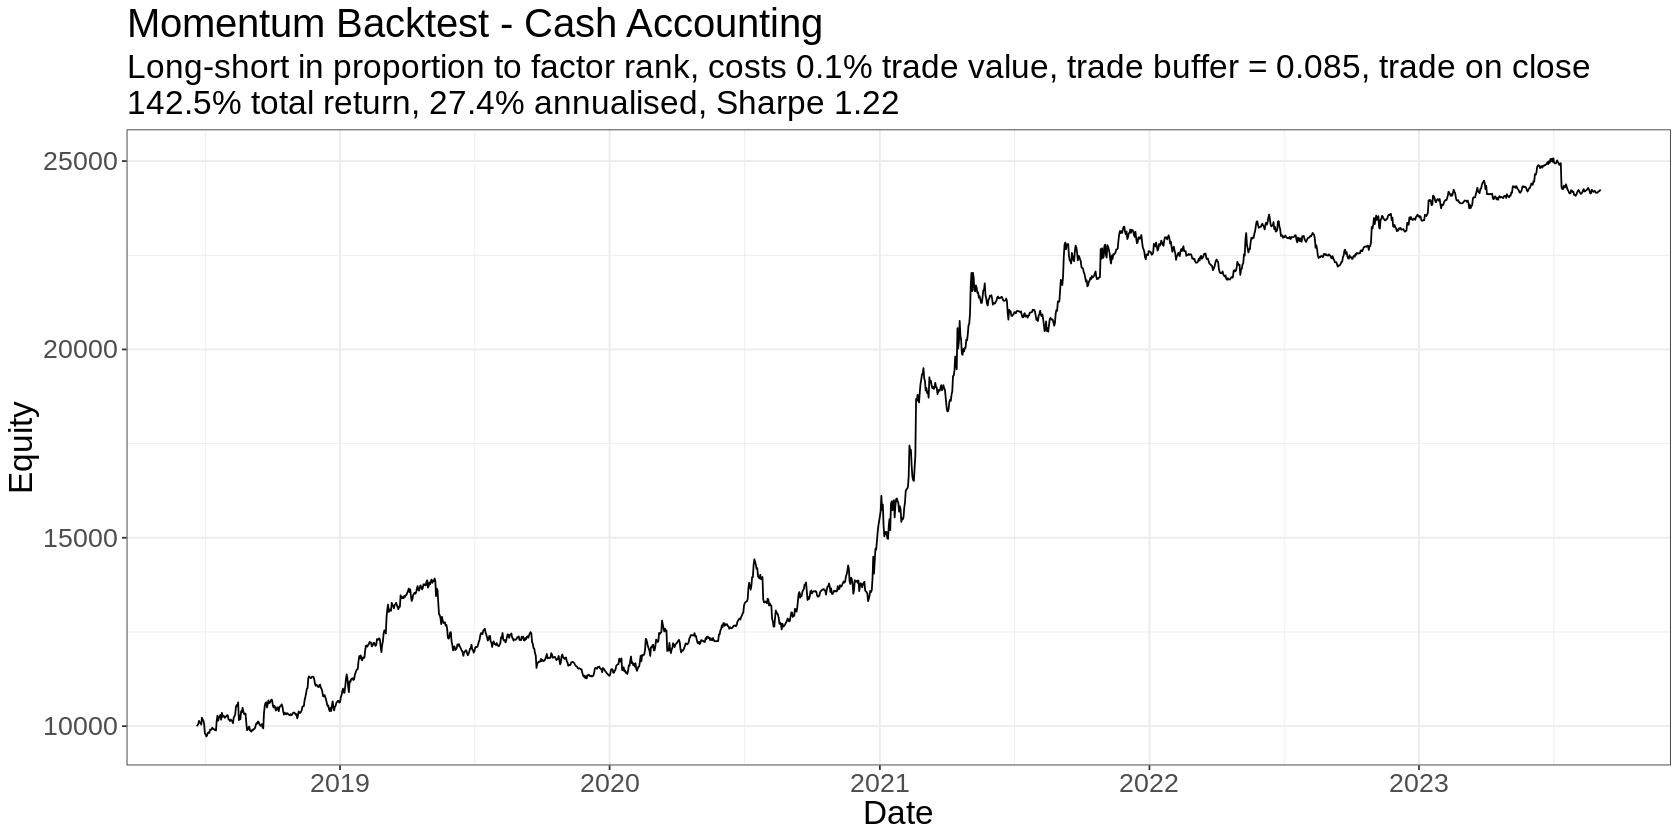

In [23]:
trade_buffer <- 0.085

results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)
plot_results(results_df)

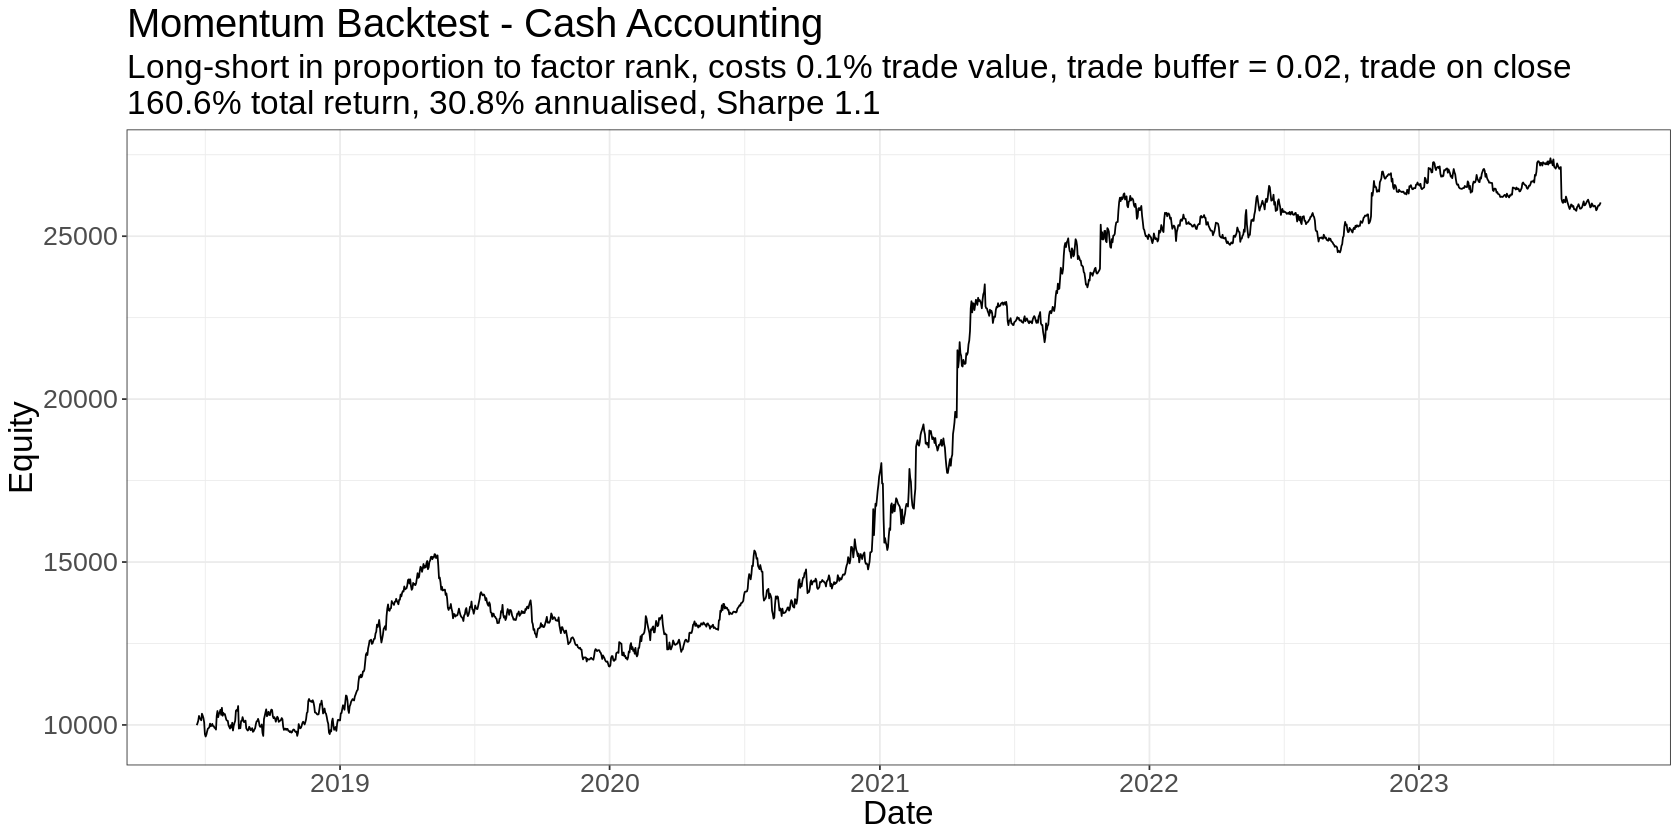

In [24]:
trade_buffer <- 0.02

results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)

plot_results(results_df)

Let's get a feel for the historical daily turnover and costs of this approach:

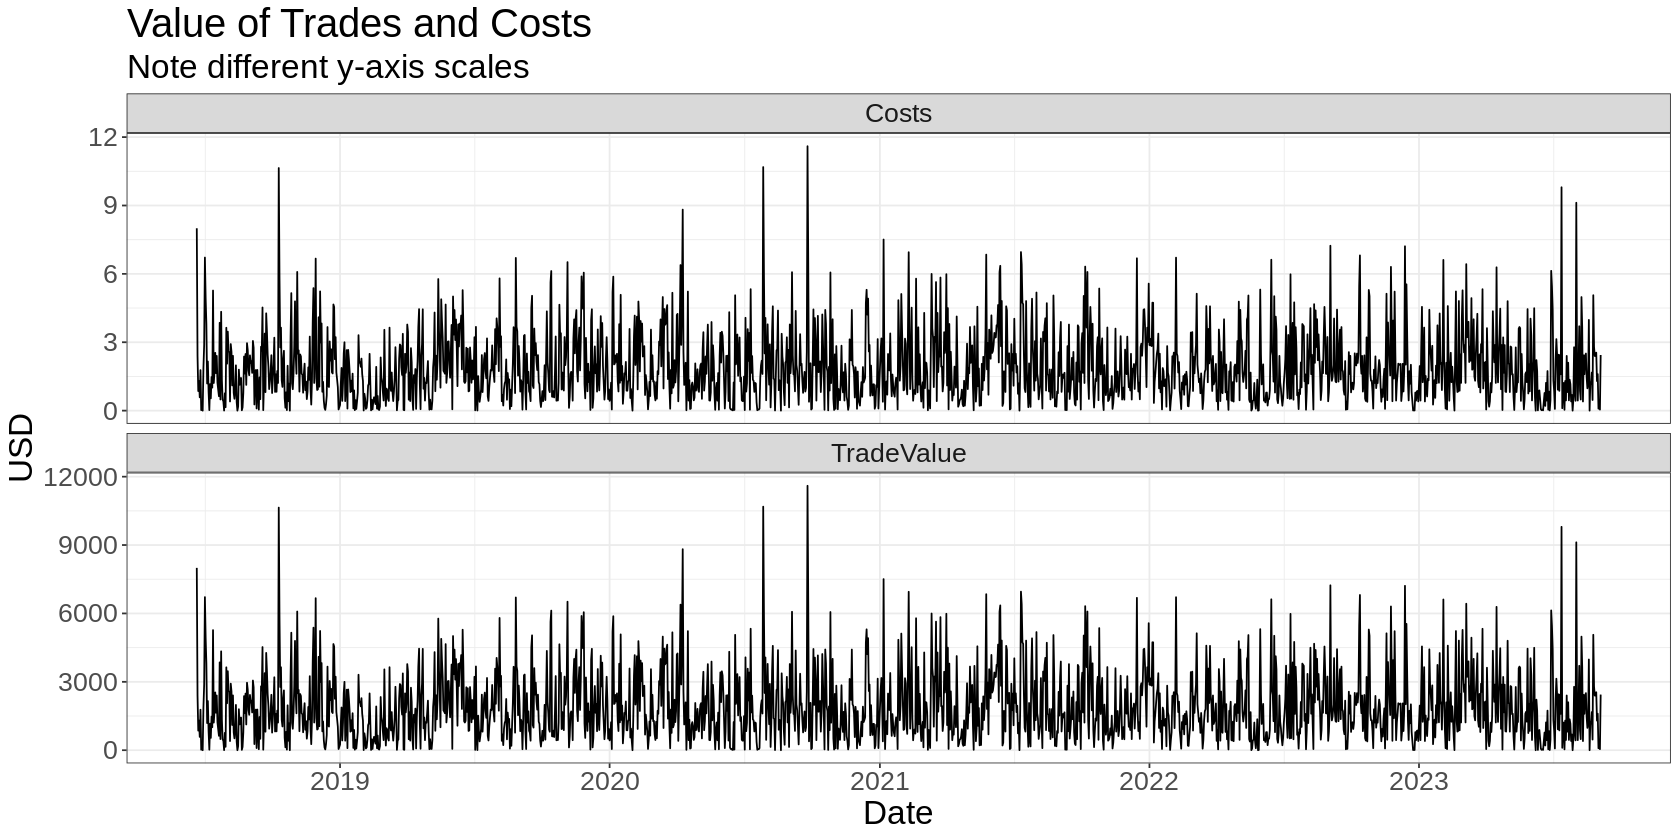

In [25]:
results_df %>%
  group_by(Date) %>%
  summarise(
    TradeValue = sum(abs(TradeValue), na.rm = TRUE),
    Costs = sum(Commission, na.rm = TRUE)
  ) %>%
  pivot_longer(-Date, names_to = "param", values_to = "value") %>%
  ggplot(aes(x = Date, y = value)) +
    geom_line() +
    facet_wrap(~param, ncol = 1, scales = "free_y") +
      labs(
        y = "USD",
        title = "Value of Trades and Costs",
        subtitle = "Note different y-axis scales"
      )

And how our exposures change over time:

Check traded value of inidividual coins:

Also check the edge case of when weight flips from positive to negative but remains inside trade buffer. I think we want to trade in that case?

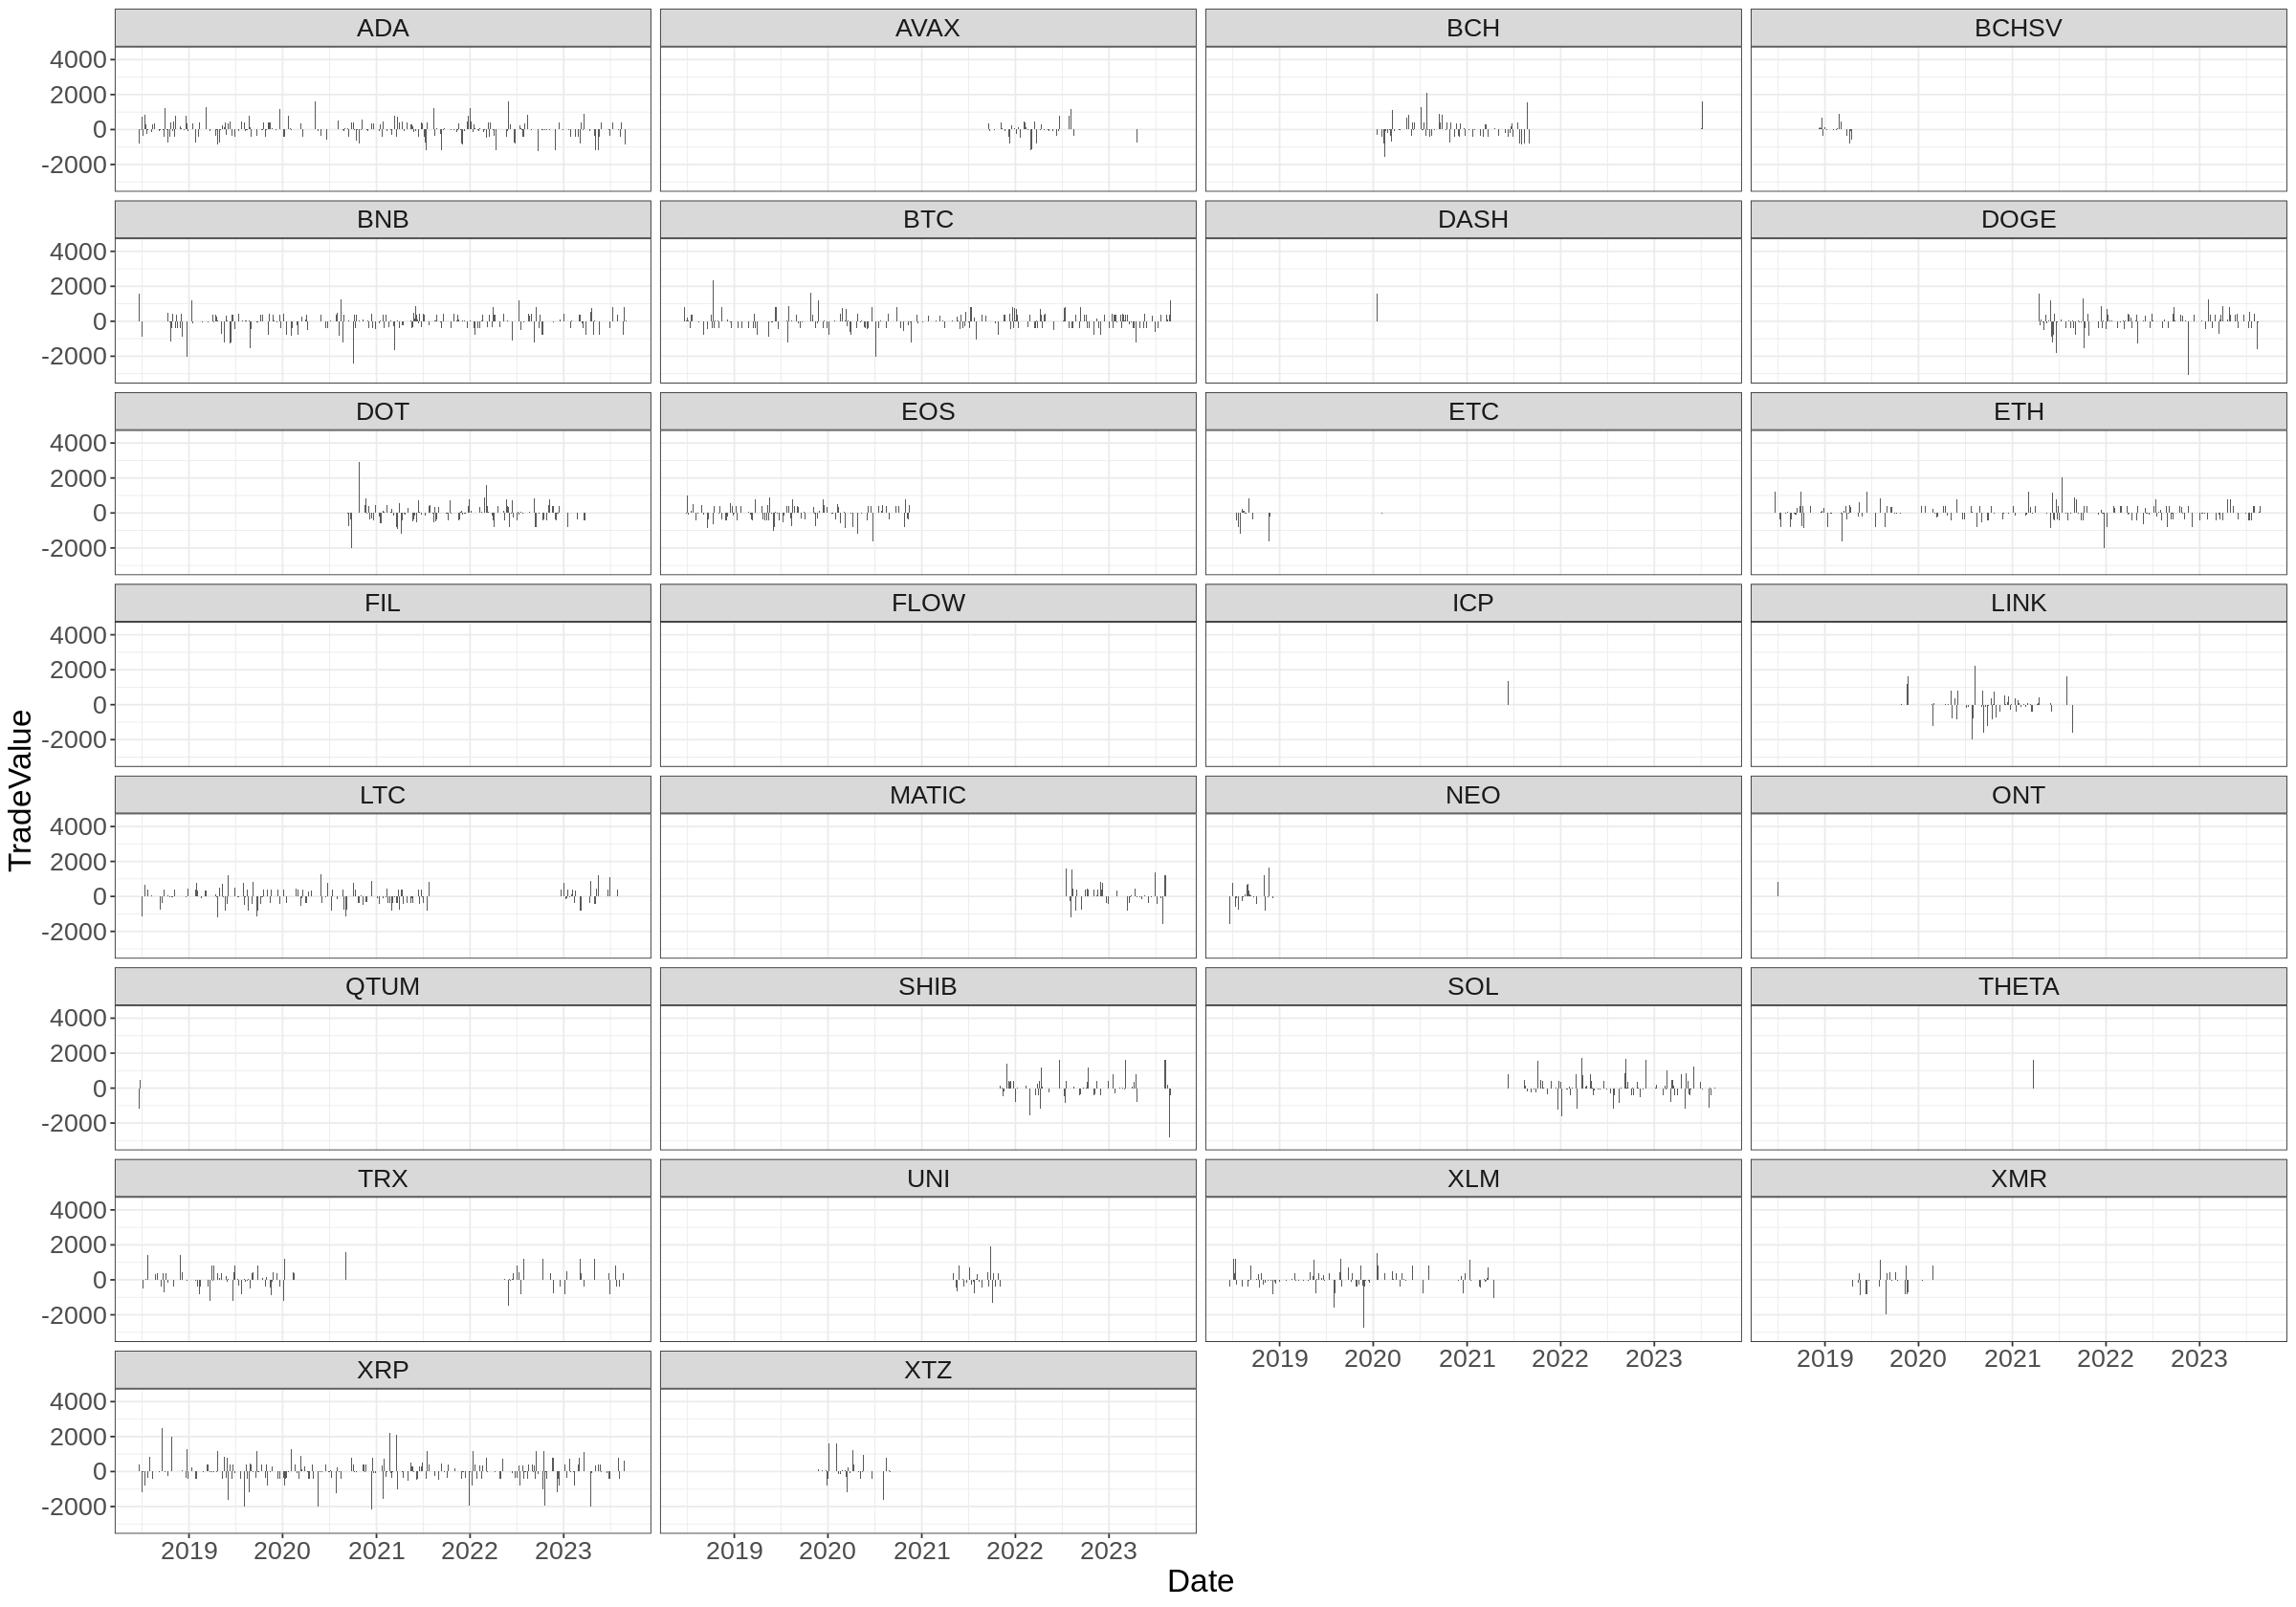

In [27]:
options(repr.plot.width = 20, repr.plot.height=14)

results_df %>%
  filter(Ticker != "Cash", abs(TradeValue) > 0) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~Ticker, ncol = 4)

# set back to default
options(repr.plot.width = 14, repr.plot.height=7)

Look at how much we turn over major coins:

Warning message:
“Removed 288 rows containing missing values (`position_stack()`).”


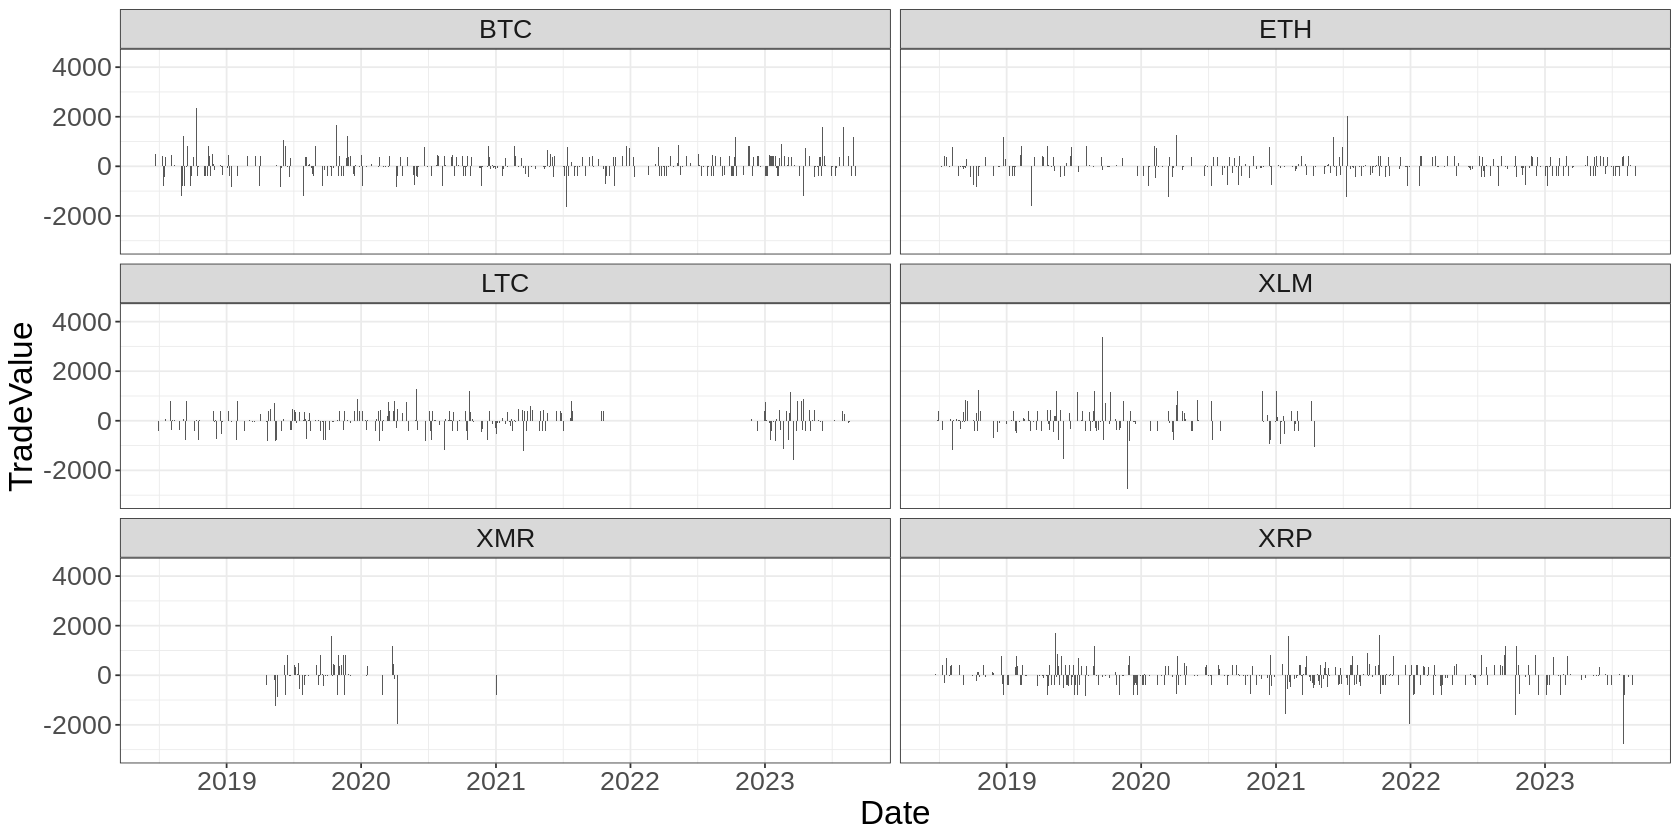

In [28]:
results_df %>%
  filter(Ticker %in% c("BTC", "ETH", "LTC", "XLM", "XMR", "XRP")) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~Ticker, ncol = 2)

It isn't insanely active, as we'd expect from our trade buffer parameter. However, there are some instances where it seems to flip position quite suddenly. May be worth looking into that.

**TODO:** calculate turnover

### Check backtest trades

First day of trading

In [31]:
head(backtest_df)

Date,Close_ADA,Close_BNB,Close_BTC,Close_EOS,Close_ETH,Close_LTC,Close_NEO,Close_QTUM,Close_XLM,⋯,theo_weight_LOOM,theo_weight_RDNT,theo_weight_EDU,theo_weight_SUI,theo_weight_FLOKI,theo_weight_PEPE,theo_weight_SNT,theo_weight_MAV,theo_weight_PENDLE,theo_weight_ARKM
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-06-21,0.15821,16.9407,6724.75,10.3966,526.65,96.82,37.580,10.204,0.22677,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-22,0.13948,15.3934,6071.07,8.7092,463.81,85.48,33.120,9.014,0.20170,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-23,0.13868,15.7099,6191.26,8.4839,476.40,83.14,34.300,8.870,0.20282,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-24,0.13050,14.4368,6136.79,8.0400,453.72,81.35,31.287,7.994,0.19338,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-25,0.13524,14.8145,6234.14,8.3422,460.12,81.72,31.700,8.305,0.19751,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-26,0.12865,14.1117,6155.75,7.8004,438.47,77.27,30.510,8.527,0.18585,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [33]:
trade_check_df <- backtest_df %>%
  filter(Date == universe_start_date) %>%
  select(Date, starts_with("Close")) %>%
  select(where(~sum(is.na(.x)) == 0)) %>%
  pivot_longer(-Date, names_to = "coin", values_to = "price") %>%
  mutate(coin = stringr::str_remove(coin, "Close_")) %>%
  left_join(
    backtest_df %>%
      filter(Date == universe_start_date) %>%
      select(Date, starts_with("theo")) %>%
      select(where(~sum(is.na(.x)) == 0)) %>%
      pivot_longer(-Date, names_to = "coin", values_to = "theo_weight") %>%
      mutate(coin = stringr::str_remove(coin, "theo_weight_")),
    by = c("Date", "coin")
  ) %>%
  mutate(
    trades = case_when(
      theo_weight > 0 ~ 10000*(theo_weight - trade_buffer)/price,
      theo_weight == 0 ~ 0,
      TRUE ~ 10000*(theo_weight + trade_buffer)/price
    )
  )

trade_check_df %>%
  left_join(results_df, by = c("Date" = "Date", "coin" = "Ticker")) %>%
  mutate(
    check_value_against_weight = Value == ifelse(
      theo_weight == 0,
      0,
      ifelse(
        theo_weight > 0,
        (theo_weight - trade_buffer)*initial_cash,
        (theo_weight + trade_buffer)*initial_cash
      )
    )
  )

Date,coin,price,theo_weight,trades,Close,Position,Value,Trades,TradeValue,Commission,check_value_against_weight
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
2018-06-21,ADA,0.15821,-0.10,-5056.5703811,0.15821,-5056.5703811,-800,-5056.5703811,-800,0.8,TRUE
2018-06-21,BNB,16.94070,0.18,94.4471008,16.94070,94.4471008,1600,94.4471008,1600,1.6,TRUE
2018-06-21,BTC,6724.75000,0.10,0.1189635,6724.75000,0.1189635,800,0.1189635,800,0.8,TRUE
2018-06-21,EOS,10.39660,0.02,0.0000000,10.39660,0.0000000,0,0.0000000,0,0.0,TRUE
2018-06-21,ETH,526.65000,0.14,2.2785531,526.65000,2.2785531,1200,2.2785531,1200,1.2,TRUE
2018-06-21,LTC,96.82000,-0.02,0.0000000,96.82000,0.0000000,0,0.0000000,0,0.0,TRUE
2018-06-21,NEO,37.58000,-0.18,-42.5758382,37.58000,-42.5758382,-1600,-42.5758382,-1600,1.6,TRUE
2018-06-21,QTUM,10.20400,-0.14,-117.6009408,10.20400,-117.6009408,-1200,-117.6009408,-1200,1.2,TRUE
2018-06-21,XLM,0.22677,-0.06,-1763.9017507,0.22677,-1763.9017507,-400,-1763.9017507,-400,0.4,TRUE


A random day of trading

In [37]:
this_date <- "2021-04-23"

trade_check_df <- backtest_df %>%
  filter(Date == this_date) %>%
  select(Date, starts_with("Close")) %>%
  select(where(~sum(is.na(.x)) == 0)) %>%
  pivot_longer(-Date, names_to = "coin", values_to = "price") %>%
  mutate(coin = stringr::str_remove(coin, "Close_")) %>%
  left_join(
    backtest_df %>%
      filter(Date == this_date) %>%
      select(Date, starts_with("theo")) %>%
      select(where(~sum(is.na(.x)) == 0)) %>%
      pivot_longer(-Date, names_to = "coin", values_to = "theo_weight") %>%
      mutate(coin = stringr::str_remove(coin, "theo_weight_")),
    by = c("Date", "coin")
  ) %>%
  na.omit()

  # mutate(
  #   trades = case_when(
  #     theo_weight > 0 ~ 10000*(theo_weight - trade_buffer)/price,
  #     theo_weight == 0 ~ 0,
  #     TRUE ~ 10000*(theo_weight + trade_buffer)/price
  #   )
  # ) %>%
  # na.omit()

# join today's actual weights
trade_check_df %>%
  left_join(
    results_df %>%
      filter(Date == this_date) %>%
      na.omit() %>%
      mutate(
        actual_weight = Value/initial_cash
      ) %>%
      select(Ticker, actual_weight),
    by = c("coin" = "Ticker")
  ) %>%
  mutate(
    # is a trade expected tomorrow?
    trade_expected = case_when(
      theo_weight <= (actual_weight - trade_buffer) | theo_weight >= (actual_weight + trade_buffer) ~ TRUE,
      TRUE ~ FALSE
    ),
    # when we expect a change, is our final position as expceted? (easier to deal with than calculation expected trades)
    position_expected = case_when(
      theo_weight >= (actual_weight + trade_buffer) ~ 10000*(theo_weight - trade_buffer)/price,
      theo_weight <= (actual_weight - trade_buffer) ~ 10000*(theo_weight + trade_buffer)/price,
      TRUE ~ NA_real_
    )
  ) %>%
  # join today's trades
  left_join(
    results_df %>%
      filter(Date == this_date),
    by = c("Date" = "Date", "coin" = "Ticker")
  )

Date,coin,price,theo_weight,actual_weight,trade_expected,position_expected,Close,Position,Value,Trades,TradeValue,Commission
<date>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-04-23,ADA,1.129440e+00,-0.10,-0.10709568,FALSE,NA,1.129440e+00,-948.21932313,-1070.9568,0.0000000,0.00000,0.00000000
2021-04-23,BNB,5.129069e+02,0.10,0.08058592,FALSE,NA,5.129069e+02,1.57116072,805.8592,0.0000000,0.00000,0.00000000
2021-04-23,BTC,5.046905e+04,-0.14,-0.14421387,FALSE,NA,5.046905e+04,-0.02857471,-1442.1387,0.0000000,0.00000,0.00000000
2021-04-23,ETH,2.316470e+03,-0.02,-0.03854039,FALSE,NA,2.316470e+03,-0.16637551,-385.4039,0.0000000,0.00000,0.00000000
2021-04-23,LTC,2.356200e+02,0.02,0.00000000,TRUE,0.00000,2.356200e+02,0.00000000,0.0000,0.0000000,0.00000,0.00000000
2021-04-23,XRP,1.121670e+00,0.14,0.12000000,TRUE,1069.83337,1.121670e+00,1069.83337345,1200.0000,40.7797598,45.74143,0.04574143
2021-04-23,LINK,3.387470e+01,-0.06,-0.04000000,TRUE,-11.80822,3.387470e+01,-11.80822266,-400.0000,-0.7174139,-24.30218,0.02430218
2021-04-23,DOGE,2.422404e-01,0.18,0.16000000,TRUE,6605.00891,2.422404e-01,6605.00890851,1600.0000,512.2821772,124.09544,0.12409544
2021-04-23,BCH,8.210000e+02,0.06,0.07158583,FALSE,NA,8.210000e+02,0.87193460,715.8583,0.0000000,0.00000,0.00000000


Where we expected a trade to happen, it happened and resulted in the correct final position.

## Long only backtest


In [38]:
# weight by rank long only
backtest_df <- universe %>%
  filter(Date >= universe_start_date) %>%
  select(Ticker, Date, Close, is_index, momo20) %>%
  # can't filter on is_index because we need price on day after it drops out of index
  # instead, replace momo values with NA if not in index then rank each day
  mutate(universe_momo20 = case_when(is_index == TRUE ~ momo20, TRUE ~ NA_real_)) %>%
  group_by(Date) %>%
  mutate(
    rank = row_number(universe_momo20),
    theo_weight = rank/sum(rank, na.rm = TRUE)
  ) %>%
  select(Ticker, Date, Close, theo_weight) %>%
  pivot_wider(names_from = Ticker, values_from = c(Close, theo_weight))  # pivot wider guarantees prices and theo_weight are date aligned

head(backtest_df)

Date,Close_ADA,Close_BNB,Close_BTC,Close_EOS,Close_ETH,Close_LTC,Close_NEO,Close_QTUM,Close_XLM,⋯,theo_weight_LOOM,theo_weight_RDNT,theo_weight_EDU,theo_weight_SUI,theo_weight_FLOKI,theo_weight_PEPE,theo_weight_SNT,theo_weight_MAV,theo_weight_PENDLE,theo_weight_ARKM
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-06-21,0.15821,16.9407,6724.75,10.3966,526.65,96.82,37.580,10.204,0.22677,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-22,0.13948,15.3934,6071.07,8.7092,463.81,85.48,33.120,9.014,0.20170,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-23,0.13868,15.7099,6191.26,8.4839,476.40,83.14,34.300,8.870,0.20282,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-24,0.13050,14.4368,6136.79,8.0400,453.72,81.35,31.287,7.994,0.19338,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-25,0.13524,14.8145,6234.14,8.3422,460.12,81.72,31.700,8.305,0.19751,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-26,0.12865,14.1117,6155.75,7.8004,438.47,77.27,30.510,8.527,0.18585,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [39]:
# get weights as a wide matrix (could do equal weight, in proportion to factor/signal, top n etc)
# here we do proportional to factor rank and allow long only
# note that date column will get converted to unix timestamp
# note that when our universe is young, we might not have 10 tradables since we need some lookback period to calculate the first factor value for the tenth asset.
backtest_theo_weights <- backtest_df %>%
  select(Date, starts_with("theo_weight_")) %>%
  data.matrix()

# NA weights should be zero
backtest_theo_weights[is.na(backtest_theo_weights)] <- 0

head(backtest_theo_weights)

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- backtest_df %>%
  select(Date, starts_with("Close_")) %>%
  data.matrix()

head(backtest_prices)

Date,theo_weight_ADA,theo_weight_BNB,theo_weight_BTC,theo_weight_EOS,theo_weight_ETH,theo_weight_LTC,theo_weight_NEO,theo_weight_QTUM,theo_weight_XLM,⋯,theo_weight_LOOM,theo_weight_RDNT,theo_weight_EDU,theo_weight_SUI,theo_weight_FLOKI,theo_weight_PEPE,theo_weight_SNT,theo_weight_MAV,theo_weight_PENDLE,theo_weight_ARKM
17703,0.05454545,0.1818182,0.1454545,0.10909091,0.1636364,0.09090909,0.01818182,0.03636364,0.07272727,⋯,0,0,0,0,0,0,0,0,0,0
17704,0.05454545,0.1818182,0.1636364,0.03636364,0.1454545,0.10909091,0.01818182,0.07272727,0.09090909,⋯,0,0,0,0,0,0,0,0,0,0
17705,0.07272727,0.1818182,0.1636364,0.01818182,0.1454545,0.09090909,0.03636364,0.05454545,0.10909091,⋯,0,0,0,0,0,0,0,0,0,0
17706,0.07272727,0.1818182,0.1636364,0.05454545,0.1454545,0.10909091,0.03636364,0.01818182,0.09090909,⋯,0,0,0,0,0,0,0,0,0,0
17707,0.07272727,0.1818182,0.1636364,0.03636364,0.1454545,0.09090909,0.01818182,0.05454545,0.10909091,⋯,0,0,0,0,0,0,0,0,0,0
17708,0.05454545,0.1818182,0.1636364,0.01818182,0.1454545,0.10909091,0.03636364,0.09090909,0.07272727,⋯,0,0,0,0,0,0,0,0,0,0


Date,Close_ADA,Close_BNB,Close_BTC,Close_EOS,Close_ETH,Close_LTC,Close_NEO,Close_QTUM,Close_XLM,⋯,Close_LOOM,Close_RDNT,Close_EDU,Close_SUI,Close_FLOKI,Close_PEPE,Close_SNT,Close_MAV,Close_PENDLE,Close_ARKM
17703,0.15821,16.9407,6724.75,10.3966,526.65,96.82,37.580,10.204,0.22677,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17704,0.13948,15.3934,6071.07,8.7092,463.81,85.48,33.120,9.014,0.20170,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17705,0.13868,15.7099,6191.26,8.4839,476.40,83.14,34.300,8.870,0.20282,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17706,0.13050,14.4368,6136.79,8.0400,453.72,81.35,31.287,7.994,0.19338,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17707,0.13524,14.8145,6234.14,8.3422,460.12,81.72,31.700,8.305,0.19751,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17708,0.12865,14.1117,6155.75,7.8004,438.47,77.27,30.510,8.527,0.18585,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


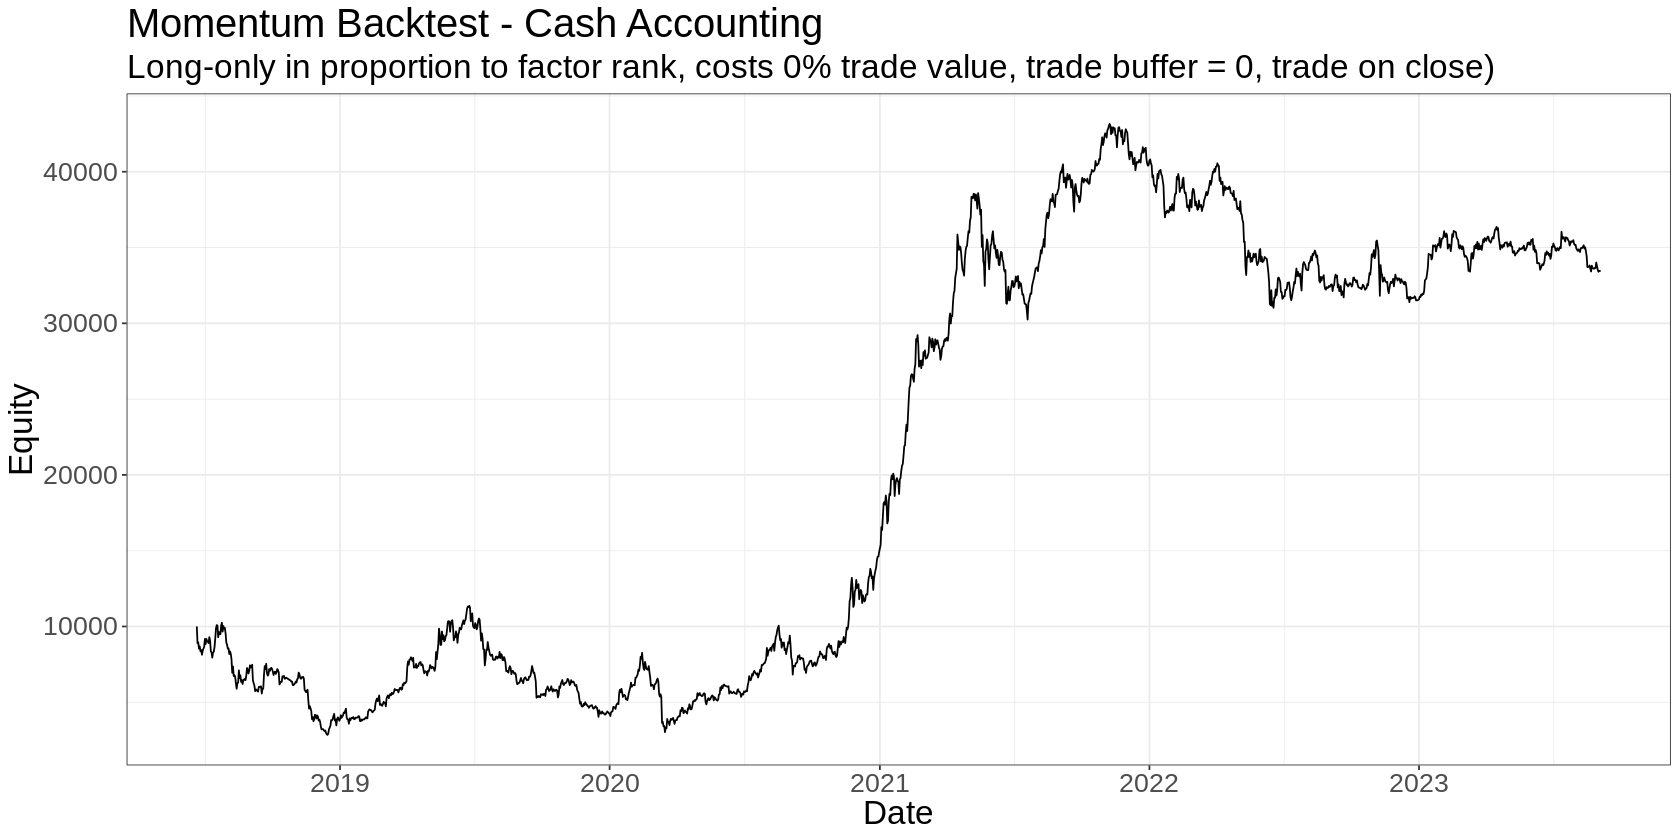

In [40]:
# cost-free backtest

# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
fee_tier <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)
p <- plot_results(results_df)
p + labs(subtitle = glue("Long-only in proportion to factor rank, costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on close)"))

### Long only when 20d momo is positive

Issues with this:
* could get highly concentrated
* needs checking

In [41]:
# weight by rank long only when momo20 is positive
backtest_df <- universe %>%
  filter(Date >= universe_start_date) %>%
  select(Ticker, Date, Close, is_index, momo20) %>%
  # can't filter on is_index because we need price on day after it drops out of index
  # instead, replace momo values with NA if not in index then rank each day
  mutate(universe_momo20 = case_when(is_index == TRUE & momo20 > 0 ~ momo20, TRUE ~ NA_real_)) %>%
  group_by(Date) %>%
  mutate(
    rank = row_number(universe_momo20),
    theo_weight = rank/sum(rank, na.rm = TRUE)
  ) %>%
  select(Ticker, Date, Close, theo_weight) %>%
  pivot_wider(names_from = Ticker, values_from = c(Close, theo_weight))  # pivot wider guarantees prices and theo_weight are date aligned

head(backtest_df)

Date,Close_ADA,Close_BNB,Close_BTC,Close_EOS,Close_ETH,Close_LTC,Close_NEO,Close_QTUM,Close_XLM,⋯,theo_weight_LOOM,theo_weight_RDNT,theo_weight_EDU,theo_weight_SUI,theo_weight_FLOKI,theo_weight_PEPE,theo_weight_SNT,theo_weight_MAV,theo_weight_PENDLE,theo_weight_ARKM
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2018-06-21,0.15821,16.9407,6724.75,10.3966,526.65,96.82,37.580,10.204,0.22677,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-22,0.13948,15.3934,6071.07,8.7092,463.81,85.48,33.120,9.014,0.20170,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-23,0.13868,15.7099,6191.26,8.4839,476.40,83.14,34.300,8.870,0.20282,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-24,0.13050,14.4368,6136.79,8.0400,453.72,81.35,31.287,7.994,0.19338,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-25,0.13524,14.8145,6234.14,8.3422,460.12,81.72,31.700,8.305,0.19751,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2018-06-26,0.12865,14.1117,6155.75,7.8004,438.47,77.27,30.510,8.527,0.18585,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [42]:
# get weights as a wide matrix (could do equal weight, in proportion to factor/signal, top n etc)
# here we do proportional to factor rank and allow long only when momo20 is positive
# note that date column will get converted to unix timestamp
# note that when our universe is young, we might not have 10 tradables since we need some lookback period to calculate the first factor value for the tenth asset.
backtest_theo_weights <- backtest_df %>%
  select(Date, starts_with("theo_weight_")) %>%
  data.matrix()

# NA weights should be zero
backtest_theo_weights[is.na(backtest_theo_weights)] <- 0

head(backtest_theo_weights)

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- backtest_df %>%
  select(Date, starts_with("Close_")) %>%
  data.matrix()

head(backtest_prices)

Date,theo_weight_ADA,theo_weight_BNB,theo_weight_BTC,theo_weight_EOS,theo_weight_ETH,theo_weight_LTC,theo_weight_NEO,theo_weight_QTUM,theo_weight_XLM,⋯,theo_weight_LOOM,theo_weight_RDNT,theo_weight_EDU,theo_weight_SUI,theo_weight_FLOKI,theo_weight_PEPE,theo_weight_SNT,theo_weight_MAV,theo_weight_PENDLE,theo_weight_ARKM
17703,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
17704,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
17705,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
17706,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
17707,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
17708,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Date,Close_ADA,Close_BNB,Close_BTC,Close_EOS,Close_ETH,Close_LTC,Close_NEO,Close_QTUM,Close_XLM,⋯,Close_LOOM,Close_RDNT,Close_EDU,Close_SUI,Close_FLOKI,Close_PEPE,Close_SNT,Close_MAV,Close_PENDLE,Close_ARKM
17703,0.15821,16.9407,6724.75,10.3966,526.65,96.82,37.580,10.204,0.22677,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17704,0.13948,15.3934,6071.07,8.7092,463.81,85.48,33.120,9.014,0.20170,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17705,0.13868,15.7099,6191.26,8.4839,476.40,83.14,34.300,8.870,0.20282,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17706,0.13050,14.4368,6136.79,8.0400,453.72,81.35,31.287,7.994,0.19338,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17707,0.13524,14.8145,6234.14,8.3422,460.12,81.72,31.700,8.305,0.19751,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
17708,0.12865,14.1117,6155.75,7.8004,438.47,77.27,30.510,8.527,0.18585,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


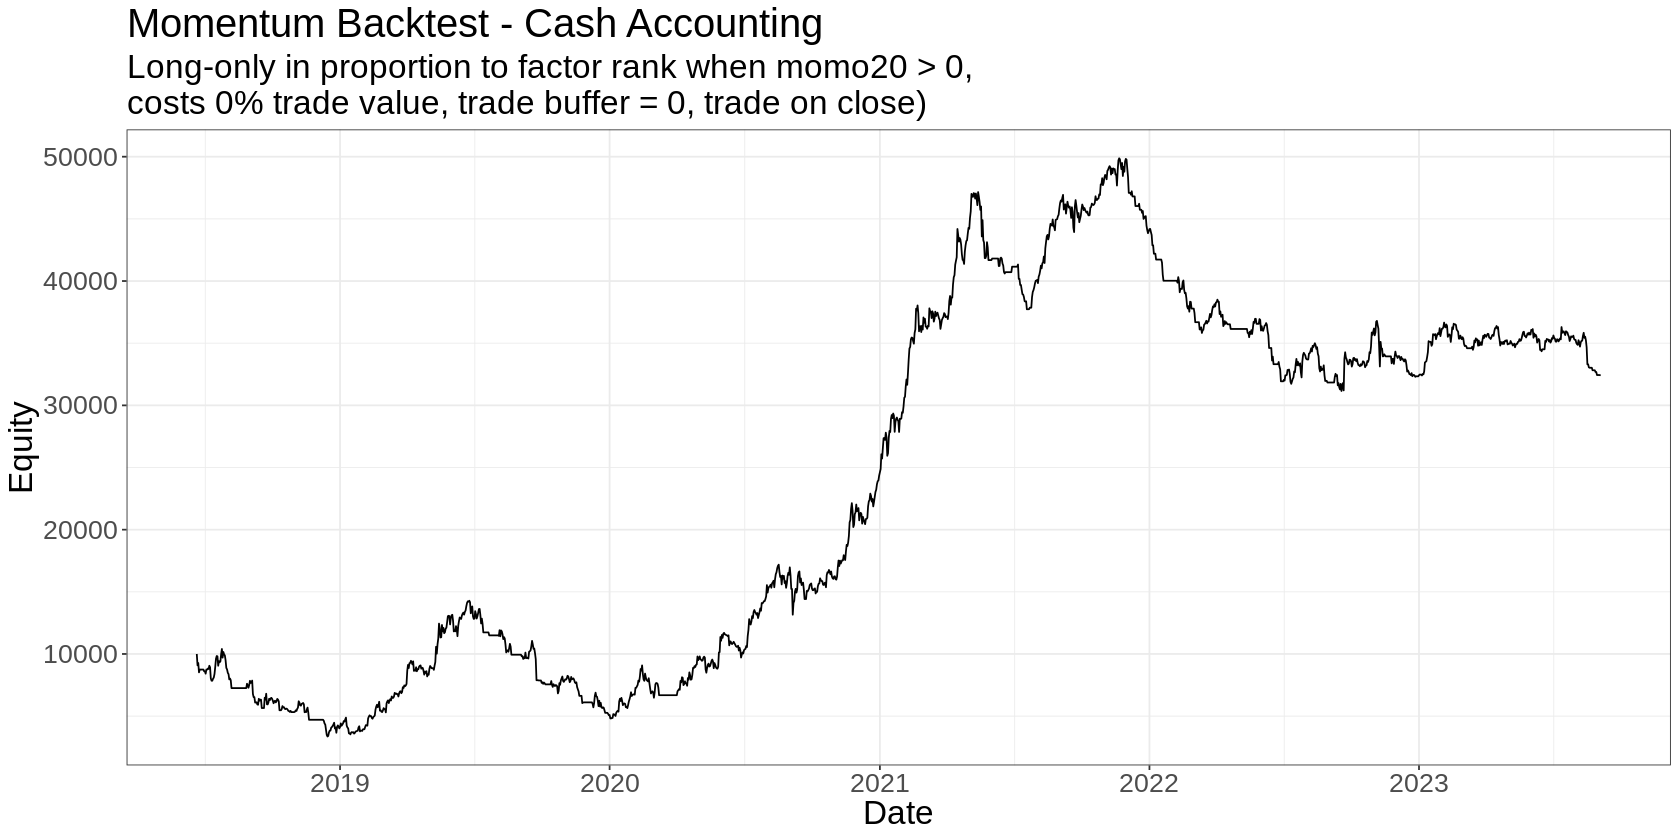

In [43]:
# cost-free backtest

# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
fee_tier <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(backtest_prices, backtest_theo_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits)
p <- plot_results(results_df)
p + labs(
  subtitle = glue(
    "Long-only in proportion to factor rank when momo20 > 0,
    costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on close)"
    )
)